## Active Learning

Download the titanic dataset here: https://drive.google.com/file/d/0Bz9_0VdXvv9bbVhpOEMwUDJ2elU/view?usp=sharing

In this exercise, we will simulate active learning. We will keep the small sample of observations for testing and we will test how quality of the model rises when we use active learning to choose labeled observations.

In [1]:
# Load the Data into variable df

In [15]:
import pandas as pd
df = pd.read_csv('titanic_train.csv')

In [16]:
df['Pclass'] = df['Pclass'].astype('object')

In [17]:
# TEST SAMPLE
# USE THIS SAMPLE ONLY FOR TESTING
test_df = df.sample(n=100, random_state=42)
# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]

In [18]:
# FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

In [19]:
df = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Survived']]
start_df = start_df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Survived']]
test_df = test_df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Survived']]

### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations from **df** to your trainset (choose the observation using active learning approach) 
    - score all observations in df and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50% 
3. refit the model and evaluate on **test_df** again.    
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

In [20]:
start_df.head()

,Pclass,Sex,Age,Fare,Embarked,Survived
288,2,male,42.0,13.0000,S,1
42,3,male,NaN,7.8958,C,0
416,2,female,34.0,32.5000,S,1
329,1,female,16.0,57.9792,C,1
587,1,male,60.0,79.2000,C,1


In [118]:
start_df.shape

(100, 6)

In [21]:
start_y = start_df['Survived']

In [22]:
start_X = start_df.drop(columns='Survived')

In [24]:
start_X.dtypes

Pclass       object
Sex          object
Age         float64
Fare        float64
Embarked     object
dtype: object

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC

In [26]:
numeric_transform = Pipeline([('impute_median', SimpleImputer(strategy='median')), 
                              ('scaling', StandardScaler())])
categorical_transform = Pipeline([('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False))])

preprocessing = ColumnTransformer([('numeric', numeric_transform, ['Age', 'Fare']), 
                                        ('categorical', categorical_transform, ['Pclass', 'Sex', 'Embarked'])])

In [48]:
pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', SVC(probability=True))
])

In [49]:
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('model', SVC(probability=True))])

In [50]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix

In [51]:
pipe.fit(start_X, start_y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('model', SVC(probability=True))])

In [52]:
test_X = test_df.drop(columns='Survived')
test_y = test_df['Survived']

In [53]:
test_ypred = pipe.predict(test_X)

In [54]:
print(classification_report(test_y, test_ypred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        60
           1       0.71      0.75      0.73        40

    accuracy                           0.78       100
   macro avg       0.77      0.78      0.77       100
weighted avg       0.78      0.78      0.78       100



In [55]:
confusion_matrix(test_y, test_ypred)

array([[48, 12],
       [10, 30]])

In [56]:
# iterating - adding more observations
df_X = df.drop(columns='Survived')
df_y = df['Survived']

In [58]:
# make predictions on entire dataset 
df_ypred = pipe.predict_proba(df_X)

In [59]:
df_ypred

array([[0.841621  , 0.158379  ],
       [0.18245326, 0.81754674],
       [0.19958455, 0.80041545],
       ...,
       [0.19483488, 0.80516512],
       [0.20593321, 0.79406679],
       [0.83813797, 0.16186203]])

In [67]:
df_X['Survived_pred'] = df_ypred[:,0]

In [91]:
df_X.head()

,Pclass,Sex,Age,Fare,Embarked
1,1,female,38.0,71.2833,C
2,3,female,26.0,7.9250,S
3,1,female,35.0,53.1000,S
8,3,female,27.0,11.1333,S
9,2,female,14.0,30.0708,C


In [93]:
# filter out data that model is least sure about (low predict_proba)
df_leastConf = df[df_X['Survived_pred']<0.5]

In [95]:
df_leastConf.head()

,Pclass,Sex,Age,Fare,Embarked,Survived
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,1
3,1,female,35.0,53.1000,S,1
8,3,female,27.0,11.1333,S,1
9,2,female,14.0,30.0708,C,1


In [96]:
# sample 10 from least confident predictions
df_leastConf10 = df_leastConf.sample(10, replace=False)

In [99]:
X10 = df_leastConf10.drop(columns='Survived')
y10 = df_leastConf10['Survived']

In [100]:
# add 10 from least confident to start dataframe 
start_X_i1 = pd.concat([start_X,X10])
start_y_i1 = pd.concat([start_y,y10])

In [101]:
pipe.fit(start_X_i1, start_y_i1)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot-encode',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('model', SVC(probability=True))])

In [103]:
test_ypred_i1 = pipe.predict(test_X)

In [104]:
print(classification_report(test_y, test_ypred_i1))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        60
           1       0.71      0.75      0.73        40

    accuracy                           0.78       100
   macro avg       0.77      0.78      0.77       100
weighted avg       0.78      0.78      0.78       100



In [107]:
precision_score(test_y, test_ypred_i1)

0.7142857142857143

In [105]:
confusion_matrix(test_y, test_ypred_i1)

array([[48, 12],
       [10, 30]])

In [109]:
max_iterations = 10
prec_scores=[]
rec_scores = []
acc_scores=[]
iter_number = []
for iter in range(max_iterations):
    # sample 10 from the least confident predictions
    df_leastConf10 = df_leastConf.sample(10, replace=False)
    
    # create X and y from iterations 
    X10 = df_leastConf10.drop(columns='Survived')
    y10 = df_leastConf10['Survived']

    # add 10 new observations to the start_X, and start_y
    start_X = pd.concat([start_X,X10])
    start_y = pd.concat([start_y,y10])
    
    # fit on concatenated
    pipe.fit(start_X, start_y)

    # predict on test 
    ypred = pipe.predict(test_X)

    # count internumber
    iter_number.append(iter+1)

    # calculate score
    prec_scores.append(precision_score(test_y, ypred))
    rec_scores.append(recall_score(test_y, ypred))
    acc_scores.append(accuracy_score(test_y, ypred))
    

In [119]:
print(start_X.shape)
print(start_df.shape)

(200, 5)
(100, 6)


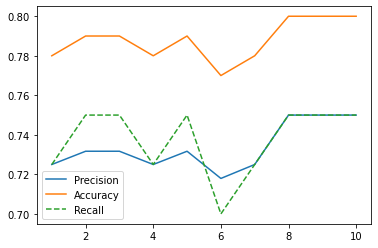

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=iter_number, y=prec_scores, label='Precision')
sns.lineplot(x=iter_number, y=acc_scores, label='Accuracy')
sns.lineplot(x=iter_number, y=rec_scores, label='Recall', linestyle="--")
plt.legend()
plt.show()